In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt

import warnings
warnings.filterwarnings('ignore')


In [2]:
data = sm.datasets.co2.load_pandas()

In [3]:
df = data.data

In [4]:
df.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [5]:
df = df['co2'].resample('MS').mean()

In [6]:
df.head()

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01           NaN
1958-07-01    315.625000
Freq: MS, Name: co2, dtype: float64

In [7]:
df.isnull().sum()

5

In [8]:
df = df.fillna(df.bfill())

In [9]:
df.head()

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
Freq: MS, Name: co2, dtype: float64

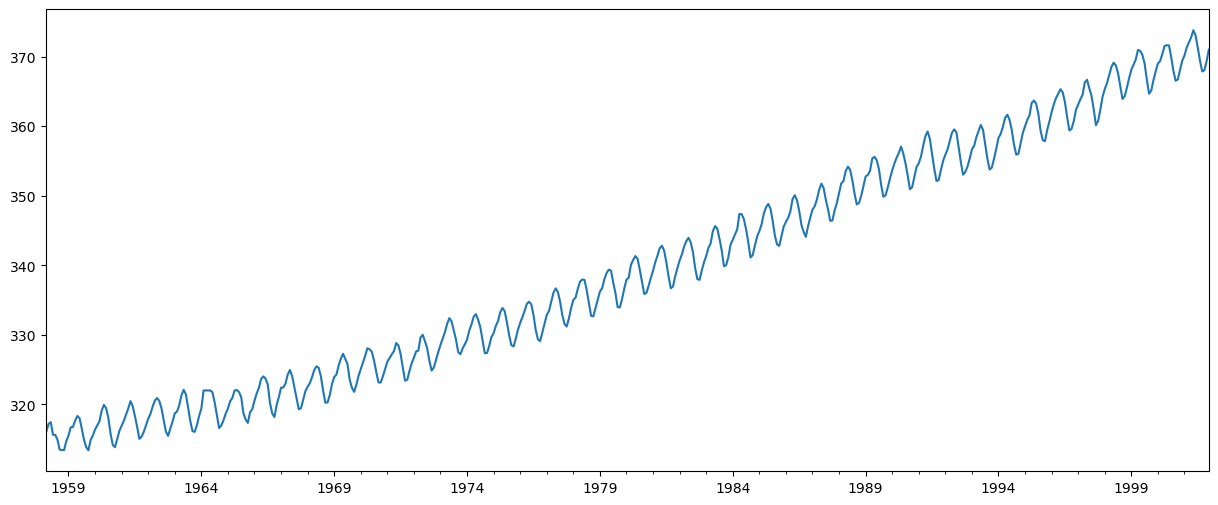

In [10]:
df.plot(figsize=(15, 6))
plt.show()

In [11]:
def ts_decompose(dataframe, model="additive", stationary=False):
    result = seasonal_decompose(dataframe, model=model)
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    axes[0].set_title("Decomposition for " + model + " model")
    axes[0].plot(dataframe, 'k', label='Original ' + model)
    axes[0].legend(loc='upper left')

    axes[1].plot(result.trend, label='Trend')
    axes[1].legend(loc='upper left')

    axes[2].plot(result.seasonal, 'g', label='Seasonality & Mean: ' + str(round(result.seasonal.mean(), 4)))
    axes[2].legend(loc='upper left')

    axes[3].plot(result.resid, 'r', label='Residuals & Mean: ' + str(round(result.resid.mean(), 4)))
    axes[3].legend(loc='upper left')
    plt.show(block=True)

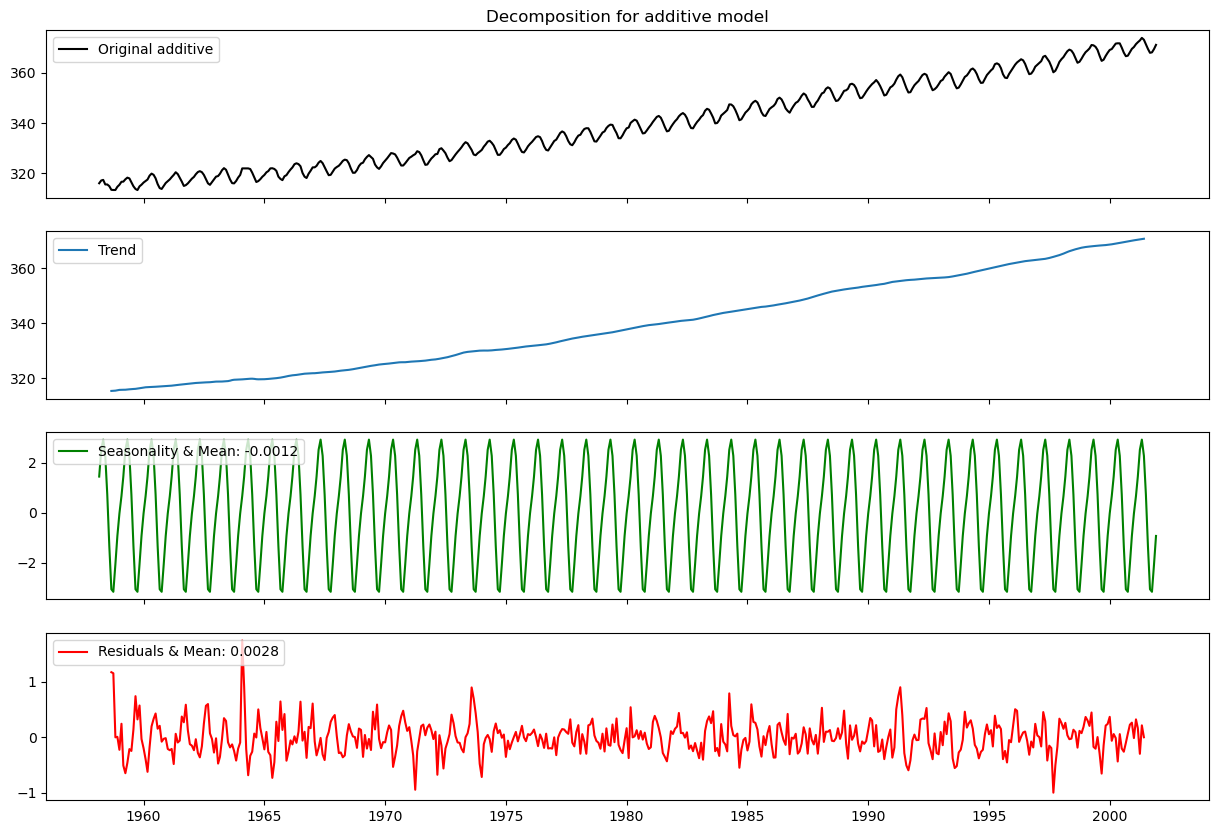

In [12]:
ts_decompose(df)

In [13]:
def is_stationary(dataframe):

    # "HO: Non-stationary"
    # "H1: Stationary"

    p_value = sm.tsa.stattools.adfuller(dataframe)[1]
    if p_value < 0.05:
        print(F"Result: Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")
    else:
        print(F"Result: Non-Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")

In [14]:
is_stationary(df)

Result: Non-Stationary (H0: non-stationary, p-value: 0.999)


In [15]:
train = df[:'1997-12-01']

In [16]:
train

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
                 ...    
1997-08-01    362.460000
1997-09-01    360.150000
1997-10-01    360.750000
1997-11-01    362.380000
1997-12-01    364.250000
Freq: MS, Name: co2, Length: 478, dtype: float64

In [17]:
len(train)

478

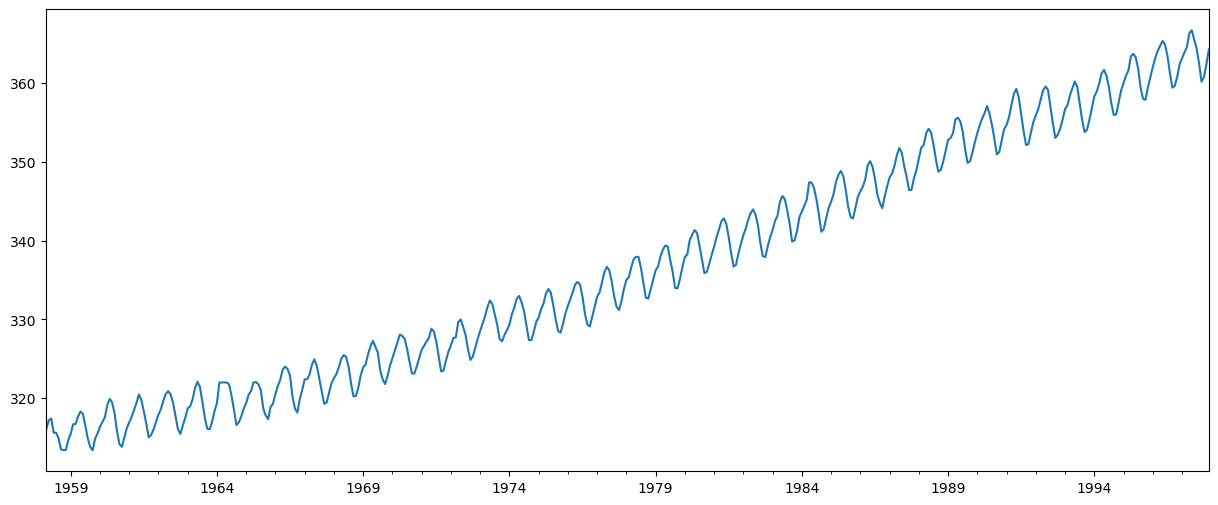

In [18]:
train.plot(figsize=(15, 6))
plt.show()

In [19]:
test = df['1998-01-01':]

In [20]:
test.head()

1998-01-01    365.340
1998-02-01    366.200
1998-03-01    367.375
1998-04-01    368.525
1998-05-01    369.140
Freq: MS, Name: co2, dtype: float64

In [21]:
len(test)

48

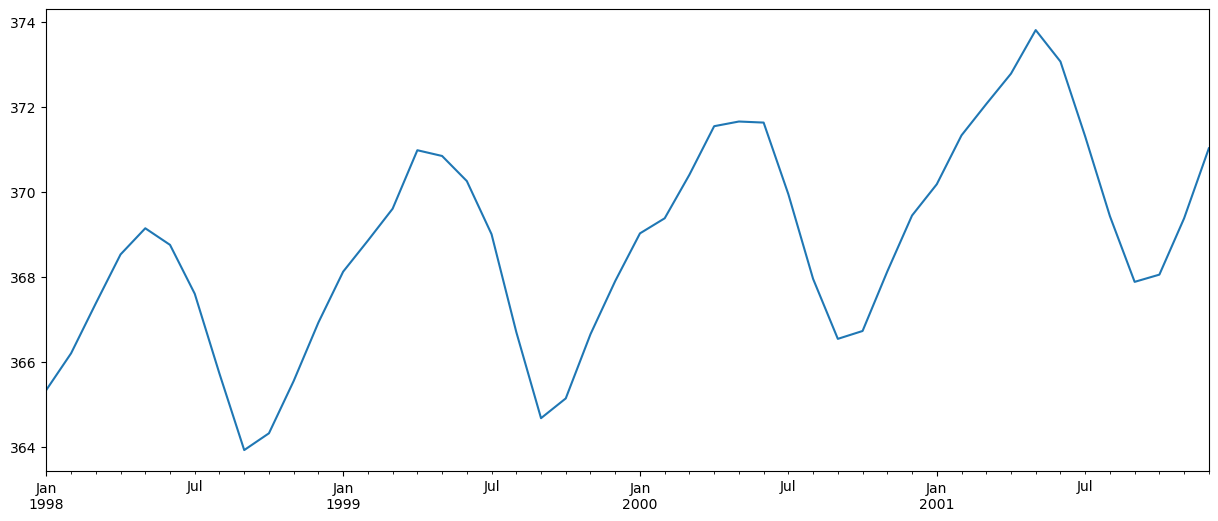

In [22]:
test.plot(figsize=(15, 6))
plt.show()

In [23]:
# Single Exponential Smoothing

In [24]:
ses_model = SimpleExpSmoothing(train).fit(smoothing_level=0.5)

In [25]:
y_pred = ses_model.forecast(48)

In [26]:
y_pred.head()

1998-01-01    363.057044
1998-02-01    363.057044
1998-03-01    363.057044
1998-04-01    363.057044
1998-05-01    363.057044
Freq: MS, dtype: float64

In [27]:
mae = mean_absolute_error(test, y_pred)
mae

5.706393369643809

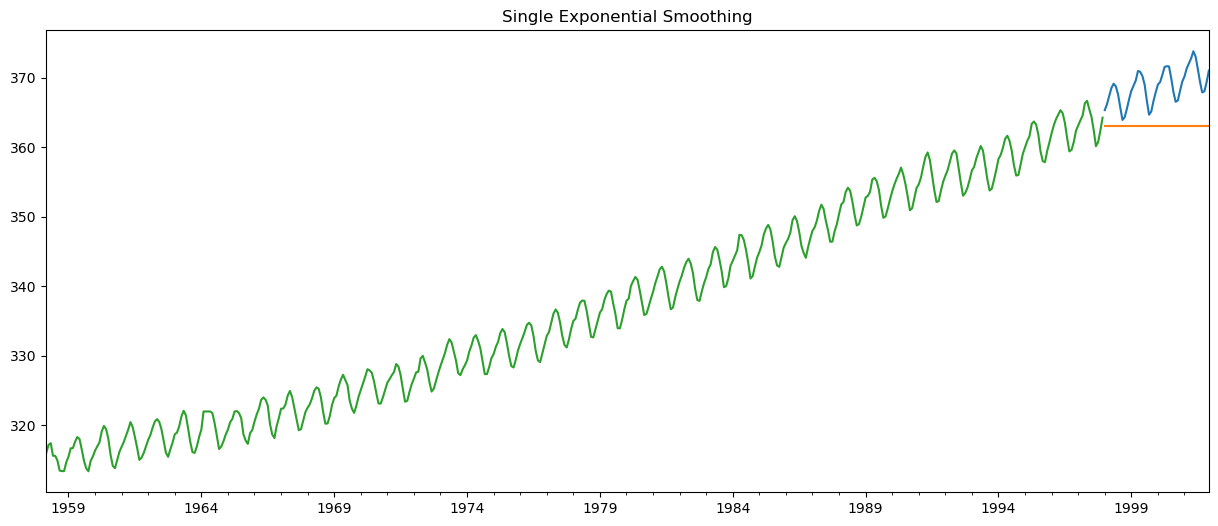

In [28]:
plt.figure(figsize=(15, 6))
test.plot()
y_pred.plot()
train.plot()
plt.title("Single Exponential Smoothing")
plt.show()

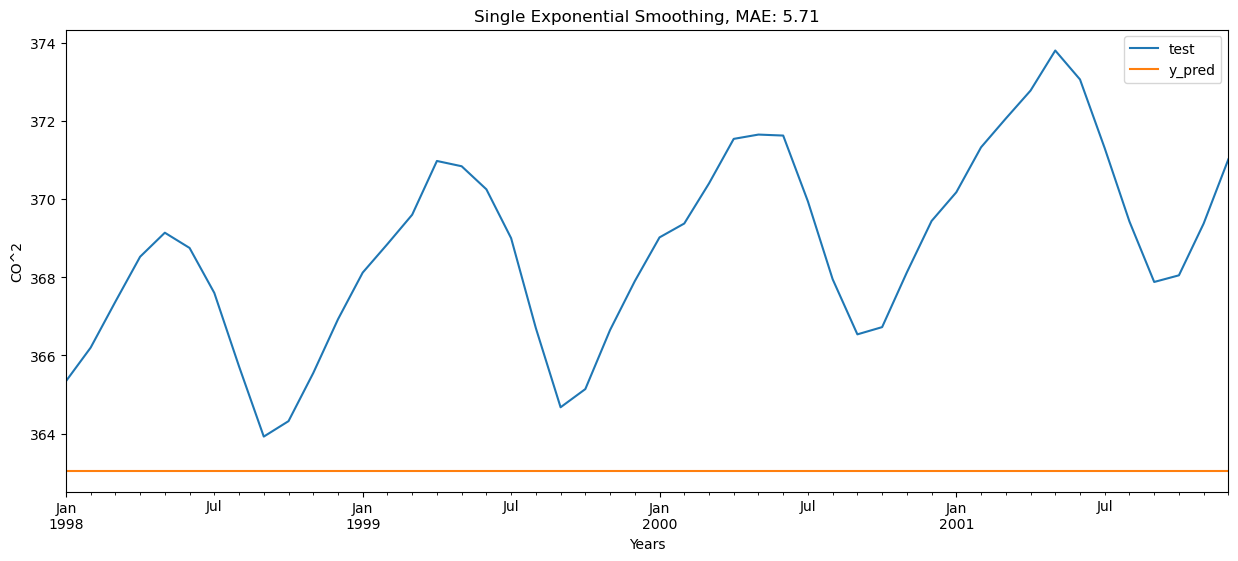

In [29]:
plt.figure(figsize=(15, 6))
test.plot(label="test")
y_pred.plot(label="y_pred")
plt.title(f"Single Exponential Smoothing, MAE: {round(mae,2)}")
plt.ylabel('CO^2')
plt.xlabel('Years')
plt.legend()
plt.show()

In [30]:
ses_model.params

{'smoothing_level': 0.5,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 316.4419309772571,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [31]:
def ses_optimizer(train, alphas, step=48):

    best_alpha, best_mae = None, float("inf")

    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)

        if mae < best_mae:
            best_alpha, best_mae = alpha, mae

        print("alpha:", round(alpha, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_mae

In [32]:
alphas = np.arange(0.8, 1, 0.01)
alphas

array([0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 ,
       0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99])

In [33]:
best_alpha, best_mae = ses_optimizer(train, alphas)

alpha: 0.8 mae: 4.953
alpha: 0.81 mae: 4.9282
alpha: 0.82 mae: 4.9035
alpha: 0.83 mae: 4.8792
alpha: 0.84 mae: 4.8551
alpha: 0.85 mae: 4.8316
alpha: 0.86 mae: 4.8091
alpha: 0.87 mae: 4.7869
alpha: 0.88 mae: 4.765
alpha: 0.89 mae: 4.7434
alpha: 0.9 mae: 4.7221
alpha: 0.91 mae: 4.7012
alpha: 0.92 mae: 4.6805
alpha: 0.93 mae: 4.6602
alpha: 0.94 mae: 4.6402
alpha: 0.95 mae: 4.6205
alpha: 0.96 mae: 4.6012
alpha: 0.97 mae: 4.5822
alpha: 0.98 mae: 4.5634
alpha: 0.99 mae: 4.5451
best_alpha: 0.99 best_mae: 4.5451


In [34]:
best_alpha

0.9900000000000002

In [35]:
best_mae

4.545056761011273

In [36]:
ses_final_model = SimpleExpSmoothing(train).fit(smoothing_level=best_alpha)

In [37]:
y_pred = ses_final_model.forecast(48)

In [38]:
y_pred.head()

1998-01-01    364.231136
1998-02-01    364.231136
1998-03-01    364.231136
1998-04-01    364.231136
1998-05-01    364.231136
Freq: MS, dtype: float64

In [39]:
mae = mean_absolute_error(test, y_pred)
mae

4.545056761011273

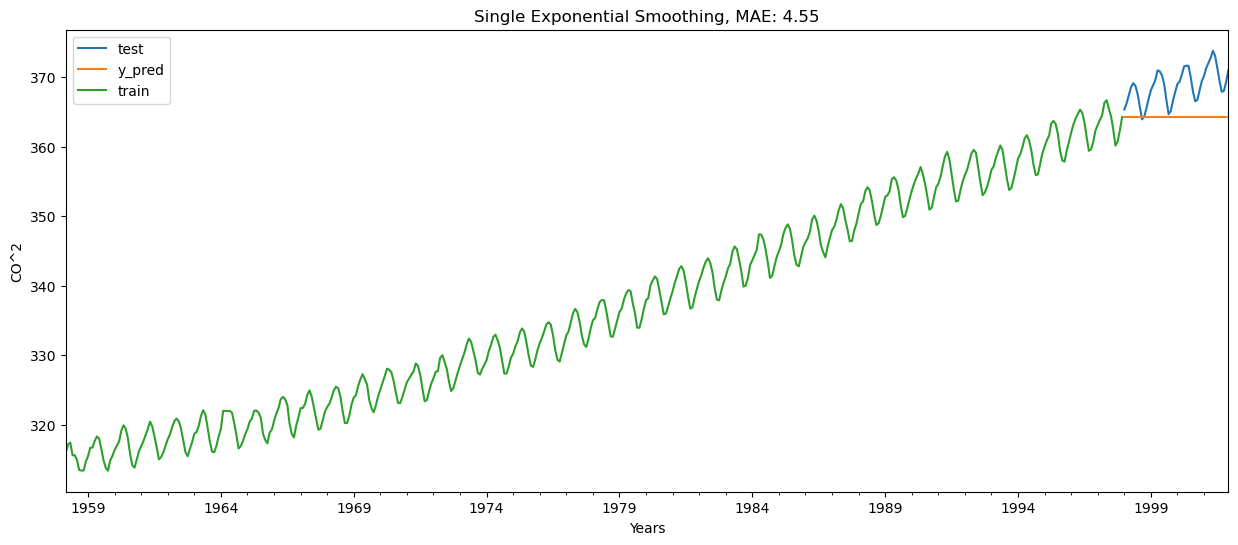

In [40]:
plt.figure(figsize=(15, 6))
test.plot(label="test")
y_pred.plot(label="y_pred")
train.plot(label="train")
plt.title(f"Single Exponential Smoothing, MAE: {round(mae,2)}")
plt.ylabel('CO^2')
plt.xlabel('Years')
plt.legend()
plt.show()

In [41]:
# Double Exponential Smoothing (DES)

In [42]:
# DES: Level (SES) + Trend

# y(t) = Level + Trend + Seasonality + Noise
# y(t) = Level * Trend * Seasonality * Noise

In [43]:
des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=0.5,
                                                         smoothing_trend=0.5)

In [44]:
y_pred = des_model.forecast(48)

In [45]:
mae = mean_absolute_error(test, y_pred)
mae

5.751835862592146

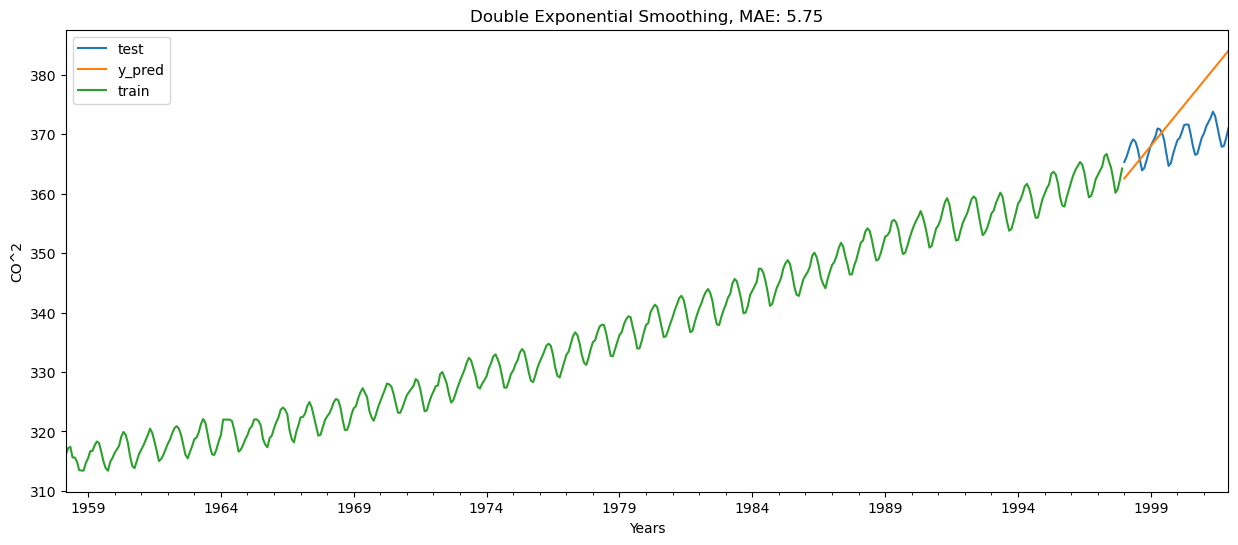

In [46]:
plt.figure(figsize=(15, 6))
test.plot(label="test")
y_pred.plot(label="y_pred")
train.plot(label="train")
plt.title(f"Double Exponential Smoothing, MAE: {round(mae,2)}")
plt.ylabel('CO^2')
plt.xlabel('Years')
plt.legend()
plt.show()

In [47]:
def des_optimizer(train, alphas, betas, step=48):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=alpha, smoothing_slope=beta)
            y_pred = des_model.forecast(step)
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
            print("alpha:", round(alpha, 2), "beta:", round(beta, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_beta, best_mae

In [48]:
alphas = np.arange(0.01, 1, 0.10)
betas = np.arange(0.01, 1, 0.10)

In [49]:
best_alpha, best_beta, best_mae = des_optimizer(train, alphas, betas)

alpha: 0.01 beta: 0.01 mae: 2.3849
alpha: 0.01 beta: 0.11 mae: 2.8294
alpha: 0.01 beta: 0.21 mae: 2.744
alpha: 0.01 beta: 0.31 mae: 2.1723
alpha: 0.01 beta: 0.41 mae: 2.8895
alpha: 0.01 beta: 0.51 mae: 2.49
alpha: 0.01 beta: 0.61 mae: 1.8196
alpha: 0.01 beta: 0.71 mae: 1.7411
alpha: 0.01 beta: 0.81 mae: 2.1932
alpha: 0.01 beta: 0.91 mae: 4.8521
alpha: 0.11 beta: 0.01 mae: 2.4334
alpha: 0.11 beta: 0.11 mae: 3.9118
alpha: 0.11 beta: 0.21 mae: 6.0908
alpha: 0.11 beta: 0.31 mae: 7.2434
alpha: 0.11 beta: 0.41 mae: 8.7305
alpha: 0.11 beta: 0.51 mae: 10.3166
alpha: 0.11 beta: 0.61 mae: 12.0066
alpha: 0.11 beta: 0.71 mae: 13.9772
alpha: 0.11 beta: 0.81 mae: 16.4873
alpha: 0.11 beta: 0.91 mae: 19.655
alpha: 0.21 beta: 0.01 mae: 2.8218
alpha: 0.21 beta: 0.11 mae: 5.7217
alpha: 0.21 beta: 0.21 mae: 8.6538
alpha: 0.21 beta: 0.31 mae: 11.7598
alpha: 0.21 beta: 0.41 mae: 15.5277
alpha: 0.21 beta: 0.51 mae: 20.1474
alpha: 0.21 beta: 0.61 mae: 25.5273
alpha: 0.21 beta: 0.71 mae: 31.2781
alpha: 0.21 be

In [50]:
best_alpha

0.01

In [51]:
best_beta

0.7100000000000001

In [52]:
best_mae 

1.7411454314823693

In [53]:
des_final_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=best_alpha,
                                                               smoothing_trend=best_beta)

In [54]:
y_pred = des_final_model.forecast(48)

In [55]:
mae = mean_absolute_error(y_pred, test)
mae

1.7411454314823693

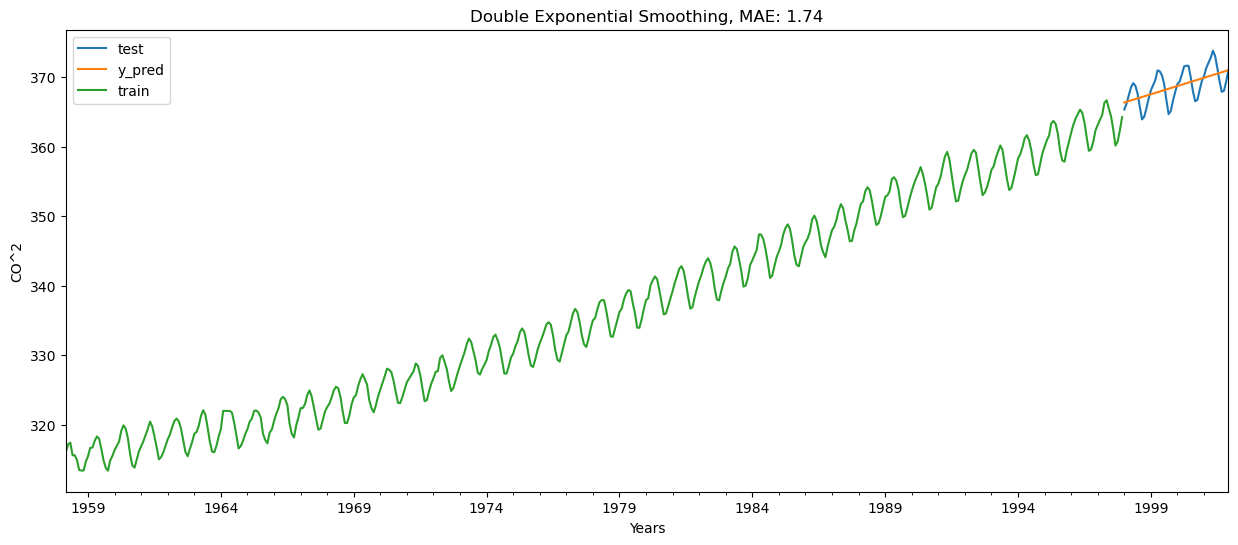

In [56]:
plt.figure(figsize=(15, 6))
test.plot(label="test")
y_pred.plot(label="y_pred")
train.plot(label="train")
plt.title(f"Double Exponential Smoothing, MAE: {round(mae,2)}")
plt.ylabel('CO^2')
plt.xlabel('Years')
plt.legend()
plt.show()

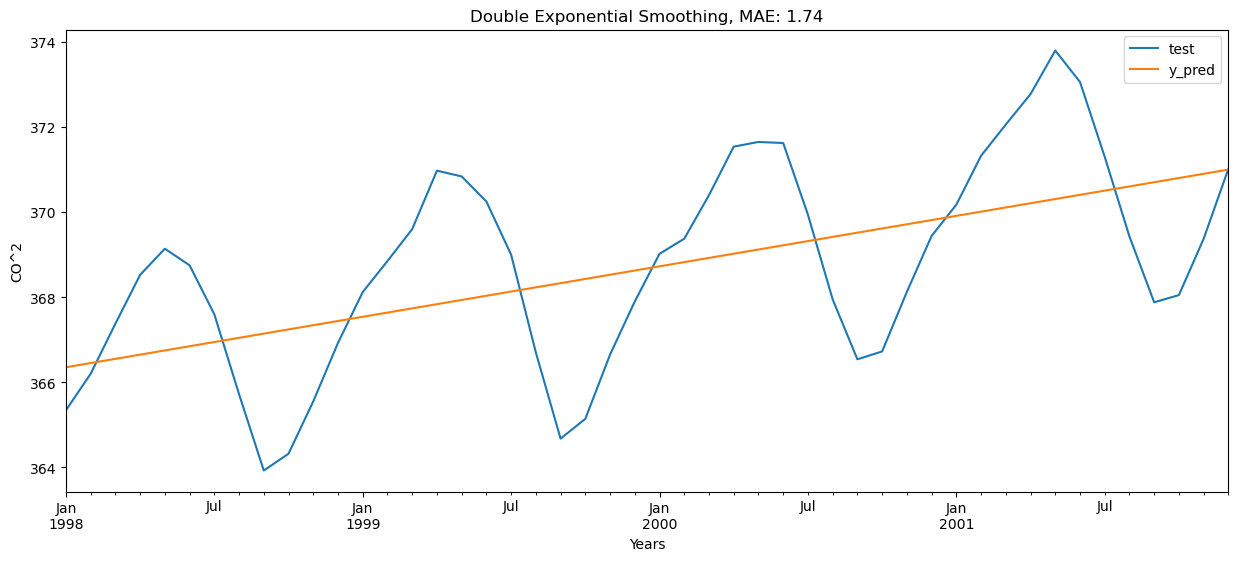

In [57]:
plt.figure(figsize=(15, 6))
test.plot(label="test")
y_pred.plot(label="y_pred")
plt.title(f"Double Exponential Smoothing, MAE: {round(mae,2)}")
plt.ylabel('CO^2')
plt.xlabel('Years')
plt.legend()
plt.show()

In [58]:
# Triple Exponential Smoothing (Holt-Winters)

In [59]:
# TES = SES + DES + Seasonality

In [60]:
tes_model = ExponentialSmoothing(train,
                                 trend="add",
                                 seasonal="add",
                                 seasonal_periods=12).fit(smoothing_level=0.5,
                                                          smoothing_trend=0.5,
                                                          smoothing_seasonal=0.5)

In [61]:
y_pred = tes_model.forecast(48)

In [62]:
mae = mean_absolute_error(y_pred, test)
mae

4.65594699301139

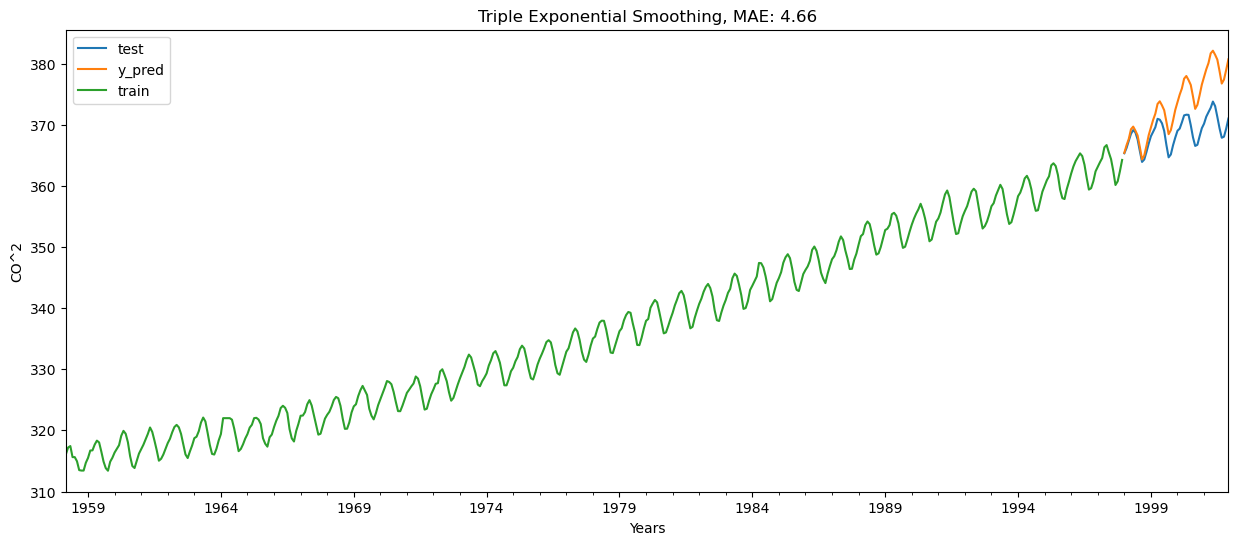

In [63]:
plt.figure(figsize=(15, 6))
test.plot(label="test")
y_pred.plot(label="y_pred")
train.plot(label="train")
plt.title(f"Triple Exponential Smoothing, MAE: {round(mae,2)}")
plt.ylabel('CO^2')
plt.xlabel('Years')
plt.legend()
plt.show()

In [64]:
alphas = betas = gammas = np.arange(0.20, 1, 0.10)

In [65]:
abg = list(itertools.product(alphas, betas, gammas))

In [66]:
abg[:10]

[(0.2, 0.2, 0.2),
 (0.2, 0.2, 0.30000000000000004),
 (0.2, 0.2, 0.4000000000000001),
 (0.2, 0.2, 0.5000000000000001),
 (0.2, 0.2, 0.6000000000000001),
 (0.2, 0.2, 0.7000000000000002),
 (0.2, 0.2, 0.8000000000000003),
 (0.2, 0.2, 0.9000000000000001),
 (0.2, 0.30000000000000004, 0.2),
 (0.2, 0.30000000000000004, 0.30000000000000004)]

In [67]:
def tes_optimizer(train, abg, step=48):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
        print([round(comb[0], 2), round(comb[1], 2), round(comb[2], 2), round(mae, 2)])

    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_mae

In [68]:
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train, abg)

[0.2, 0.2, 0.2, 0.88]
[0.2, 0.2, 0.3, 0.79]
[0.2, 0.2, 0.4, 0.76]
[0.2, 0.2, 0.5, 0.75]
[0.2, 0.2, 0.6, 0.72]
[0.2, 0.2, 0.7, 0.67]
[0.2, 0.2, 0.8, 0.67]
[0.2, 0.2, 0.9, 0.71]
[0.2, 0.3, 0.2, 0.86]
[0.2, 0.3, 0.3, 0.93]
[0.2, 0.3, 0.4, 0.94]
[0.2, 0.3, 0.5, 0.95]
[0.2, 0.3, 0.6, 1.09]
[0.2, 0.3, 0.7, 1.43]
[0.2, 0.3, 0.8, 1.95]
[0.2, 0.3, 0.9, 1.73]
[0.2, 0.4, 0.2, 1.63]
[0.2, 0.4, 0.3, 1.74]
[0.2, 0.4, 0.4, 1.64]
[0.2, 0.4, 0.5, 1.68]
[0.2, 0.4, 0.6, 2.3]
[0.2, 0.4, 0.7, 4.39]
[0.2, 0.4, 0.8, 11.66]
[0.2, 0.4, 0.9, 4.52]
[0.2, 0.5, 0.2, 2.46]
[0.2, 0.5, 0.3, 2.52]
[0.2, 0.5, 0.4, 1.94]
[0.2, 0.5, 0.5, 1.82]
[0.2, 0.5, 0.6, 1.84]
[0.2, 0.5, 0.7, 3.35]
[0.2, 0.5, 0.8, 4.63]
[0.2, 0.5, 0.9, 3.99]
[0.2, 0.6, 0.2, 3.37]
[0.2, 0.6, 0.3, 3.11]
[0.2, 0.6, 0.4, 0.72]
[0.2, 0.6, 0.5, 1.08]
[0.2, 0.6, 0.6, 1.64]
[0.2, 0.6, 0.7, 2.68]
[0.2, 0.6, 0.8, 8327.83]
[0.2, 0.6, 0.9, 151797145264.8]
[0.2, 0.7, 0.2, 4.72]
[0.2, 0.7, 0.3, 4.56]
[0.2, 0.7, 0.4, 6.58]
[0.2, 0.7, 0.5, 0.64]
[0.2, 0.7, 0.6, 1.9

[0.7, 0.5, 0.3, 4.42]
[0.7, 0.5, 0.4, 2.54]
[0.7, 0.5, 0.5, 3.05]
[0.7, 0.5, 0.6, 4.05]
[0.7, 0.5, 0.7, 3.96]
[0.7, 0.5, 0.8, 6.53]
[0.7, 0.5, 0.9, 6.02]
[0.7, 0.6, 0.2, 6.42]
[0.7, 0.6, 0.3, 5.34]
[0.7, 0.6, 0.4, 3.31]
[0.7, 0.6, 0.5, 1.38]
[0.7, 0.6, 0.6, 2.47]
[0.7, 0.6, 0.7, 3.69]
[0.7, 0.6, 0.8, 10.31]
[0.7, 0.6, 0.9, 4876.74]
[0.7, 0.7, 0.2, 7.76]
[0.7, 0.7, 0.3, 6.34]
[0.7, 0.7, 0.4, 4.47]
[0.7, 0.7, 0.5, 1.67]
[0.7, 0.7, 0.6, 1.47]
[0.7, 0.7, 0.7, 1.46]
[0.7, 0.7, 0.8, 18.45]
[0.7, 0.7, 0.9, 20987795518124.05]
[0.7, 0.8, 0.2, 9.09]
[0.7, 0.8, 0.3, 7.42]
[0.7, 0.8, 0.4, 6.18]
[0.7, 0.8, 0.5, 2.53]
[0.7, 0.8, 0.6, 0.84]
[0.7, 0.8, 0.7, 1181614.98]
[0.7, 0.8, 0.8, 3849246437299626.0]
[0.7, 0.8, 0.9, 2.9802552847290692e+16]
[0.7, 0.9, 0.2, 10.43]
[0.7, 0.9, 0.3, 8.73]
[0.7, 0.9, 0.4, 8.47]
[0.7, 0.9, 0.5, 1.99]
[0.7, 0.9, 0.6, 54579.13]
[0.7, 0.9, 0.7, 450125445266.11]
[0.7, 0.9, 0.8, 23689462478504.32]
[0.7, 0.9, 0.9, 4.906599908291605e+21]
[0.8, 0.2, 0.2, 1.93]
[0.8, 0.2, 0.3, 1.

In [69]:
best_alpha

0.8000000000000003

In [70]:
best_beta

0.5000000000000001

In [71]:
best_gamma

0.7000000000000002

In [72]:
best_mae

0.6059927585077235

In [73]:
tes_final_model = ExponentialSmoothing(train,
                                 trend="add",
                                 seasonal="add",
                                 seasonal_periods=12).fit(smoothing_level=best_alpha,
                                                          smoothing_trend=best_beta,
                                                          smoothing_seasonal=best_gamma)

In [74]:
y_pred = tes_final_model.forecast(48)

In [75]:
mae = mean_absolute_error(test, y_pred)
mae

0.6059927585077235

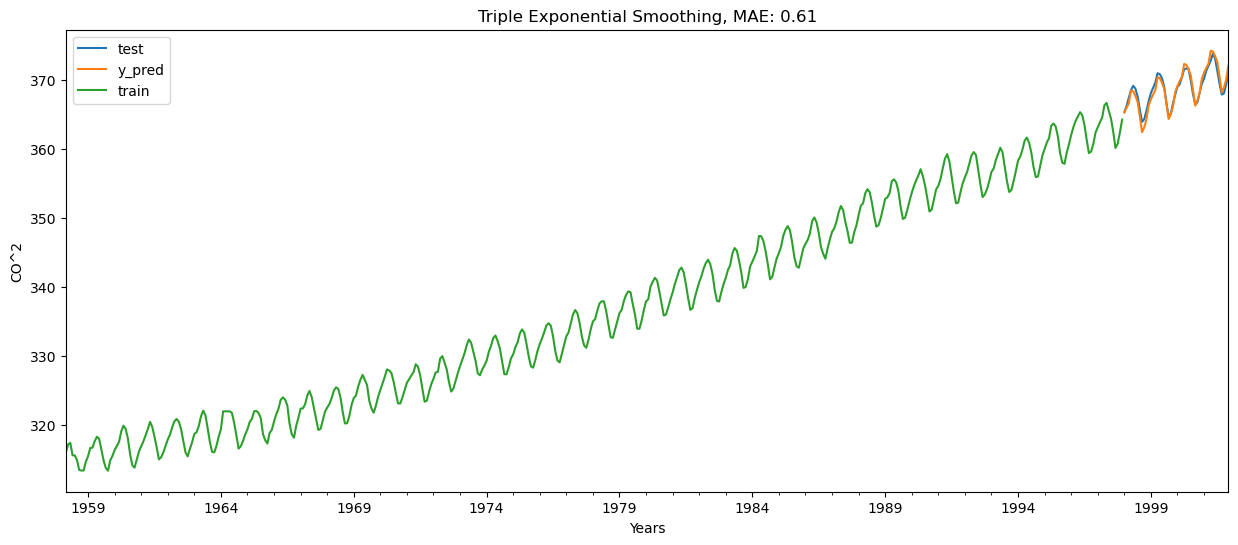

In [76]:
plt.figure(figsize=(15, 6))
test.plot(label="test")
y_pred.plot(label="y_pred")
train.plot(label="train")
plt.title(f"Triple Exponential Smoothing, MAE: {round(mae,2)}")
plt.ylabel('CO^2')
plt.xlabel('Years')
plt.legend()
plt.show()

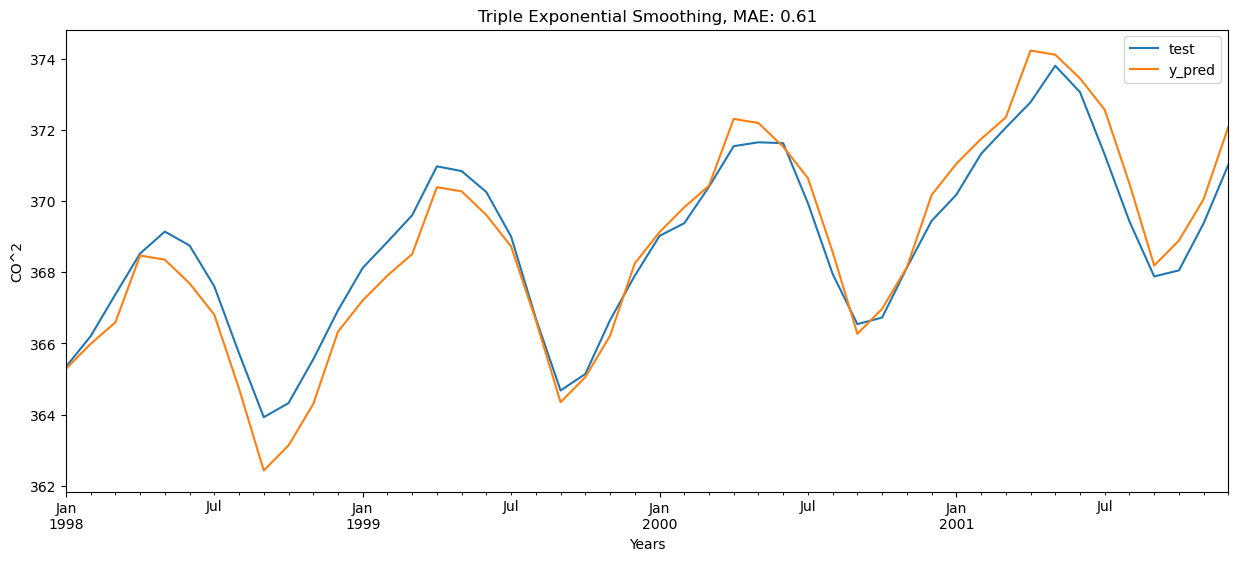

In [77]:
plt.figure(figsize=(15, 6))
test.plot(label="test")
y_pred.plot(label="y_pred")
plt.title(f"Triple Exponential Smoothing, MAE: {round(mae,2)}")
plt.ylabel('CO^2')
plt.xlabel('Years')
plt.legend()
plt.show()